Notebook purpose: evaluate how efficiently we could search for catalysts using the ML model under various constraints.

The most conspicuous constraint is to find a set number of active catalysts without any unnecessary DFT calculations
What is unnecessary? --> 100% of O2 binding calculations are to actual binding sites
So we can accept a model with lower accuracy as long as it has no false positives --> only a small penalty for false negatives

Let's say we're only willing to run 5 DFT O2 binding calculations, and we want basically all of them to show that we found active sites. We'd probably want each of these to be per catalyst, to show that we've found 5 unique active catalysts. Assuming we're working with 10% of the data as a "test" set, that's about 27 calalysts, so we want to pick the ones that the model is most confident have at least 1 site that binds O2.

Really, this is a question of whether the active sites for a set of catalysts are most likely to actually be binding
Can order by log-loss and take that as an estimate of uncertainty (is that a fair expectation?)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import GroupKFold
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.neural_network import MLPRegressor

plt.rcParams.update({'font.size': 20})

In [2]:
from ngcc_ml import data_tools
from ngcc_ml import skl_tools

In [3]:
def scale_data(train, test, feature_cols, target_col):
        scaler = StandardScaler()
        X_train_group = train[feature_cols]
        X_test_group = test[feature_cols]
        X_train_group = scaler.fit_transform(X_train_group)
        X_test_group = scaler.transform(X_test_group)
        y_test_group = test[target_col]
        y_train_group = train[target_col]
        return X_train_group, y_train_group, X_test_group, y_test_group


def group_regression_kfold_evaluate(df, feature_cols, target_col="BindingEnergy", n_splits=10, group_col="Catalyst Name"):
    
    all_mae, all_mse, all_test = [], [], []
    split_groups = GroupKFold(n_splits=n_splits).split(df[feature_cols], df[target_col], df[group_col])
    for train_inds, test_inds in split_groups:
        df_xy = df.copy()
        model_kfg = MLPRegressor(max_iter=20000, hidden_layer_sizes=(512, 256, 128, 16), learning_rate="adaptive")
        train = df_xy.iloc[train_inds]
        test = df_xy.iloc[test_inds]
        X_train_group, y_train_group, X_test_group, y_test_group = scale_data(train, test, feature_cols, target_col)
        model_kfg.fit(X_train_group, y_train_group)
        score = model_kfg.score(X_test_group, y_test_group)
        y_test_group_pred = model_kfg.predict(X_test_group)
        test = test.assign(BindingEnergy_pred=y_test_group_pred)
        mse = mean_squared_error(y_test_group, y_test_group_pred)
        mae = mean_absolute_error(y_test_group, y_test_group_pred)
        all_test.append(test)
        all_mae.append(mae)
        all_mse.append(mse)

        print('MAE of MLP on test set: {:.4f}'.format(mae))
    print("mean:", np.mean(all_mae))
    print("stdev:", np.std(all_mae))
    df_pred_aug = pd.concat(all_test)
    return all_mse, all_mae, df_pred_aug


def group_classification_kfold_evaluate(df, feature_cols, target_col="Doesitbind", n_splits=10, group_col="Catalyst Name"):
    all_scores, all_test = [], []
    split_groups = GroupKFold(n_splits=n_splits).split(df[feature_cols], df[target_col], df[group_col])
    for train_inds, test_inds in split_groups:
        model_kfg = RandomForestClassifier(n_estimators=1000, max_depth=100, class_weight={0:0.5, 1:0.5})
        df_xy = df.copy()
        train = df_xy.iloc[train_inds]
        test = df_xy.iloc[test_inds]
        X_train_group, y_train_group, X_test_group, y_test_group = scale_data(train, test, feature_cols, target_col)
        model_kfg.fit(X_train_group, y_train_group)
        score = model_kfg.score(X_test_group, y_test_group)
        y_test_group_pred = model_kfg.predict(X_test_group)
        test = test.assign(Doesitbind_pred=y_test_group_pred)
        all_test.append(test)
        all_scores.append(score)
        print('Accuracy of model on test set: {:.4f}'.format(score))
    df_pred_aug = pd.concat(all_test)
    return all_scores, df_pred_aug

In [4]:
df = pd.read_csv("/home/nricke/work/ngcc_ml/DidItBindv5.csv")
df["Doesitbind"] = df["Doesitbind"].astype("int")
df_inactive = df[df["Doesitbind"] == 0]
df_active = df[df["Doesitbind"] == 1]
df_spec = df.copy()
# set to 0 if it doesn't bind
df_spec.loc[df_spec['Doesitbind'] == 0, 'BindingEnergy'] = 0.0

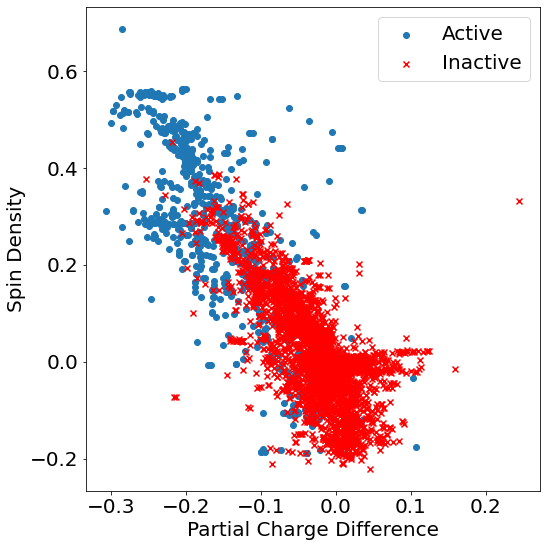

In [5]:
fig = plt.gcf()
fig.set_size_inches(8,8)
plt.ylabel("Spin Density")
plt.xlabel("Partial Charge Difference")
plt.scatter(df_active["ChargeDifference"], df_active["SpinDensity"], label="Active")
plt.scatter(df_inactive["ChargeDifference"], df_inactive["SpinDensity"], color="red", marker="x", label="Inactive")
plt.legend()
plt.tight_layout()
plt.savefig("ChargeDiffvsSpinDensity.png")

In [6]:
print(df.shape, df_spec.shape, df_active.shape, df_inactive.shape)

(4141, 36) (4141, 36) (739, 36) (3402, 36)


In [6]:
feature_cols = {"SpinDensity", "ChElPGNeutralCharge", "ChargeDifference", "IonizationEnergy", "OrthoOrPara", "Meta", "FartherThanPara", "DistanceToN", "AverageBondLength",  "NumberOfHydrogens", "IsInRingSize6", "IsInRingSize5", "NeighborSpinDensity", 'NeighborChElPGCharge', 'NeighborChargeDifference', "AromaticExtent", "RingEdge", "NumNitrogens", "NumHeteroatoms", "charge", "atom_plane_deviation", "ring_plane_deviation", "ring_nitrogens"}

In [8]:
df_reg = df.copy()
df_reg.loc[df_spec['Doesitbind'] == 0, 'BindingEnergy'] = 0.0

In [9]:
gkf_mse_reg, gkf_mae_reg, df_gkf_reg = group_regression_kfold_evaluate(df_reg, feature_cols)

MAE of MLP on test set: 0.0420
MAE of MLP on test set: 0.0273
MAE of MLP on test set: 0.0465
MAE of MLP on test set: 0.0299
MAE of MLP on test set: 0.0293
MAE of MLP on test set: 0.0279
MAE of MLP on test set: 0.0334
MAE of MLP on test set: 0.0466
MAE of MLP on test set: 0.0404
MAE of MLP on test set: 0.0331
mean: 0.035647271429972566
stdev: 0.00718205000679628


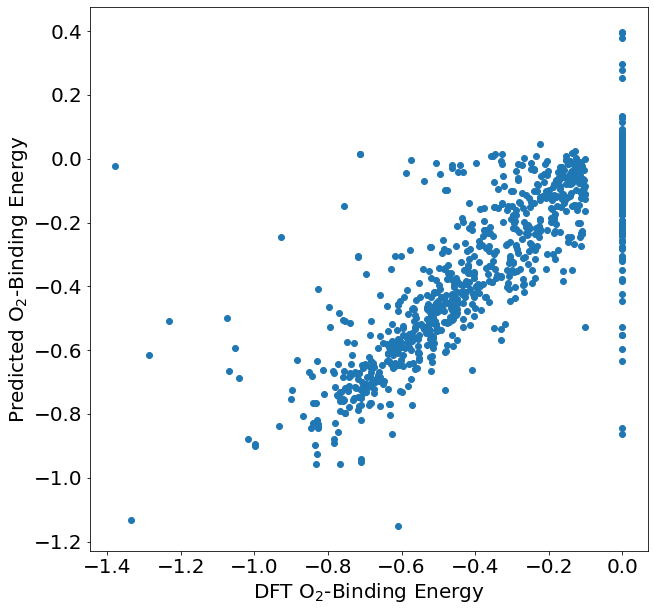

In [17]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)
plt.scatter(df_gkf_reg["BindingEnergy"], df_gkf_reg["BindingEnergy_pred"])
plt.xlabel(r"DFT O$_2$-Binding Energy")
plt.ylabel(r"Predicted O$_2$-Binding Energy")
plt.savefig("Regression_ActiveInactive_BE.png")

In [10]:
gkf_scores, df_gkf_class = group_classification_kfold_evaluate(df, feature_cols)
gkf_mse_spec, gkf_mae_spec, df_gkf_spec = group_regression_kfold_evaluate(df_active, feature_cols)

Accuracy of model on test set: 0.9615
Accuracy of model on test set: 0.9519
Accuracy of model on test set: 0.9399
Accuracy of model on test set: 0.9561
Accuracy of model on test set: 0.9610
Accuracy of model on test set: 0.9561
Accuracy of model on test set: 0.9495
Accuracy of model on test set: 0.9519
Accuracy of model on test set: 0.9351
Accuracy of model on test set: 0.9494
MAE of MLP on test set: 0.0751
MAE of MLP on test set: 0.1048
MAE of MLP on test set: 0.0583
MAE of MLP on test set: 0.0823
MAE of MLP on test set: 0.0714
MAE of MLP on test set: 0.0812
MAE of MLP on test set: 0.0577
MAE of MLP on test set: 0.0893
MAE of MLP on test set: 0.0750
MAE of MLP on test set: 0.0759
mean: 0.07711311474499967
stdev: 0.013146680453837462


In [11]:
print(len(df["Catalyst Name"].unique()), len(df_gkf_class["Catalyst Name"].unique()))

267 267


In [12]:
print(np.mean(gkf_scores), np.std(gkf_scores))
print(np.mean(gkf_mae_spec), np.std(gkf_mae_spec))

0.9512472168222608 0.00802778017057451
0.07711311474499967 0.013146680453837462


In [13]:
df_gkf_spec.to_csv("df_BindingEnergy_pred.csv")
df_gkf_class.to_csv("df_Doesitbind_pred.csv")

In [14]:
print(df_gkf_class.shape, df_gkf_spec.shape)

(4141, 37) (739, 37)


In [15]:
df[df[["Catalyst Name", "Atom Number"]].duplicated()]

,Unnamed: 0,Atom Number,Catalyst Name,CatalystO2File,Element,SpinDensity,ChElPGPositiveCharge,ChElPGNeutralCharge,ChargeDifference,Doesitbind,...,NeighborChElPGCharge,NeighborChargeDifference,AromaticExtent,RingEdge,NumNitrogens,NumHeteroatoms,ring_nitrogens,atom_plane_deviation,ring_plane_deviation,charge


In [16]:
df_gkf_class[df_gkf_class[["Catalyst Name", "Atom Number"]].duplicated()]

,Unnamed: 0,Atom Number,Catalyst Name,CatalystO2File,Element,SpinDensity,ChElPGPositiveCharge,ChElPGNeutralCharge,ChargeDifference,Doesitbind,...,NeighborChargeDifference,AromaticExtent,RingEdge,NumNitrogens,NumHeteroatoms,ring_nitrogens,atom_plane_deviation,ring_plane_deviation,charge,Doesitbind_pred


In [17]:
df_gkf_spec.columns

Index(['Unnamed: 0', 'Atom Number', 'Catalyst Name', 'CatalystO2File',
       'Element', 'SpinDensity', 'ChElPGPositiveCharge', 'ChElPGNeutralCharge',
       'ChargeDifference', 'Doesitbind', 'BondLength', 'IonizedFreeEnergy',
       'IonizationEnergy', 'BindingEnergy', 'NeutralFreeEnergy', 'OrthoOrPara',
       'Meta', 'FartherThanPara', 'DistanceToN', 'AverageBondLength',
       'BondLengthRange', 'NumberOfHydrogens', 'AromaticSize', 'IsInRingSize6',
       'IsInRingSize5', 'NeighborSpinDensity', 'NeighborChElPGCharge',
       'NeighborChargeDifference', 'AromaticExtent', 'RingEdge',
       'NumNitrogens', 'NumHeteroatoms', 'ring_nitrogens',
       'atom_plane_deviation', 'ring_plane_deviation', 'charge',
       'BindingEnergy_pred'],
      dtype='object')

In [18]:
# fill df_gkf_class BindingEnergy_pred with values from df_gkf_spec and model predictions on df_inactive
BE_relevant_cols = ["Catalyst Name", "Atom Number", "BindingEnergy_pred"]

model = MLPRegressor(max_iter=20000, hidden_layer_sizes=(512, 256, 128, 16), learning_rate="adaptive")

X_train_group = df_active[feature_cols]
X_test_group = df_inactive[feature_cols]
y_train_group = df_active["BindingEnergy"]

scaler = StandardScaler()
X_train_group = scaler.fit_transform(X_train_group)
X_test_group = scaler.transform(X_test_group)

model.fit(X_train_group, y_train_group)
y_pred = model.predict(X_test_group)

df_inactive = df_inactive.assign(BindingEnergy_pred=y_pred)
inactive_pred = df_inactive[BE_relevant_cols]
active_pred = df_gkf_spec[BE_relevant_cols]
BE_pred = pd.concat([inactive_pred, active_pred])

In [19]:
df_gkf_merge = df_gkf_class.merge(BE_pred, on=["Catalyst Name", "Atom Number"], suffixes=["","_inactive"])

In [20]:
df_gkf_merge.loc[df_gkf_merge['Doesitbind'] == 0, 'BindingEnergy'] = 0.0

In [21]:
df_gkf_merge.columns

Index(['Unnamed: 0', 'Atom Number', 'Catalyst Name', 'CatalystO2File',
       'Element', 'SpinDensity', 'ChElPGPositiveCharge', 'ChElPGNeutralCharge',
       'ChargeDifference', 'Doesitbind', 'BondLength', 'IonizedFreeEnergy',
       'IonizationEnergy', 'BindingEnergy', 'NeutralFreeEnergy', 'OrthoOrPara',
       'Meta', 'FartherThanPara', 'DistanceToN', 'AverageBondLength',
       'BondLengthRange', 'NumberOfHydrogens', 'AromaticSize', 'IsInRingSize6',
       'IsInRingSize5', 'NeighborSpinDensity', 'NeighborChElPGCharge',
       'NeighborChargeDifference', 'AromaticExtent', 'RingEdge',
       'NumNitrogens', 'NumHeteroatoms', 'ring_nitrogens',
       'atom_plane_deviation', 'ring_plane_deviation', 'charge',
       'Doesitbind_pred', 'BindingEnergy_pred'],
      dtype='object')

The situation is a little different now than before, as the model has only made predictions on the sites that are known to be active. To really put together both the classification and regression algorithms, we need to make regression predictions for the inactive sites as well.

1. If we don't train on inactive data, what do the predictions on the inactive sites look like?
2. If we set a fixed value for the inactive data and train on that, does that have a negative effect on the accuracy for predicting on the active sites?

In [22]:
df_ts = df_gkf_merge.copy()
df_ts = df_ts.sort_values(by=["BindingEnergy"])
df_ts = df_ts.assign(actual_rank=range(df_ts.shape[0]))
df_ts.head(15)[["Atom Number", "Catalyst Name", "Doesitbind", "BindingEnergy", "actual_rank"]]

,Atom Number,Catalyst Name,Doesitbind,BindingEnergy,actual_rank
2568,17,sf156x0,1,-1.378673,0
2418,2,sf39x0,1,-1.334808,1
248,5,sf261x0,1,-1.285420,2
1201,2,sf41x0,1,-1.232087,3
855,3,sf109x0,1,-1.074241,4
859,7,sf109x0,1,-1.067673,5
277,36,sf261x0,1,-1.051760,6
2987,15,sf168x0,1,-1.040843,7
3081,10,sf218x0,1,-1.018317,8
2912,22,sf110x0,1,-0.999242,9


In [23]:
df_ts_predict_bind = df_ts[df_ts["Doesitbind_pred"] == 1]
df_ts_predict_bind = df_ts_predict_bind.sort_values(by="BindingEnergy_pred")
df_ts_predict_bind = df_ts_predict_bind.assign(pred_rank=range(df_ts_predict_bind.shape[0]))

In [24]:
df_ts_pred_head = df_ts_predict_bind.sort_values(by=["BindingEnergy"]).head(15)[["Catalyst Name", "Atom Number", "pred_rank", "actual_rank"]]
df_ts_pred_head = df_ts_pred_head[df_ts_pred_head["actual_rank"] <= 14]

In [25]:
df_ts_pred_head = df_ts_pred_head.sort_values(by="pred_rank")
df_ts_pred_head

,Catalyst Name,Atom Number,pred_rank,actual_rank
2418,sf39x0,2,0,1
1201,sf41x0,2,1,3
2899,sf110x0,7,3,10
2895,sf110x0,3,4,11
2912,sf110x0,22,5,9
3081,sf218x0,10,7,8
859,sf109x0,7,28,5
855,sf109x0,3,29,4
2276,sf210x0,14,47,13
2278,sf210x0,16,74,14


In [26]:
ts_rr_all = []
nsims = 1000
for j in range(nsims):
    df_ts_rand = df_ts.assign(random_ordering=np.random.rand(df_ts.shape[0]))
    df_ts_rand = df_ts_rand.sort_values(by="random_ordering")
    df_ts_rand = df_ts_rand.assign(rand_rank=range(df_ts_rand.shape[0]))
    df_ts_rand = df_ts_rand.sort_values(by="actual_rank").head(10)
    df_ts_rand = df_ts_rand.sort_values(by="rand_rank")
    
    ts_rr_pred = []
    for i in range(10):
        rand_count = df_ts_rand.iloc[i]["rand_rank"] + 1
        pred_count = df_ts_pred_head.iloc[i]["pred_rank"] + 1
        ts_rr_pred.append(rand_count/pred_count)

    ts_rr_all.append(ts_rr_pred)

In [27]:
ts_rr_arr = np.array(ts_rr_all)
ts_mean = np.mean(ts_rr_arr, axis=0)
ts_std = np.std(ts_rr_all, axis=0)

print(ts_mean)
print()
print(ts_std)

[369.008      371.5705     283.636      301.0634     315.73216667
 284.779       91.39286207 100.9145      70.65564583  50.21977333]

[325.5460028  222.95766141 130.66375551 112.64763122  99.45338223
  72.04081332  19.11801245  16.90349161   9.3969412    4.51761864]


In [28]:
reg_mean = [251.938,      251.1335,     190.98125,    206.684,      161.026,
 171.19511111, 112.1881875,  108.48,       115.79445,     49.50586538,
  33.26965882,  30.866,       29.90214286,   8.30059447,   1.8115164 ]

reg_std = [2.30487054e+02, 1.62354413e+02, 9.36430074e+01, 8.41326775e+01,
 5.65513855e+01, 5.34623311e+01, 3.07570276e+01, 2.59472072e+01,
 2.49081149e+01, 9.38073379e+00, 5.38916854e+00, 4.33599167e+00, 3.54415625e+00, 7.62934138e-01, 1.12907134e-01]

reg_mean_10 = reg_mean[:10]
reg_std_10 = reg_std[:10]

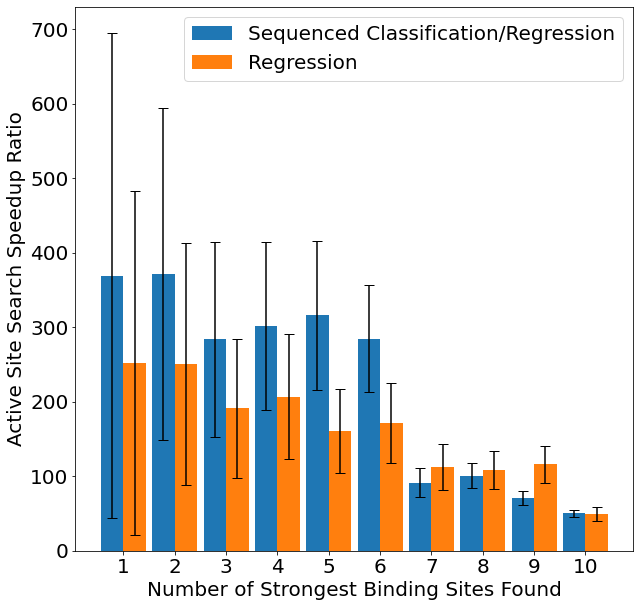

In [29]:
width = 0.44
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)
plt.bar(np.arange(10)+1-width/2, ts_mean, width, yerr=ts_std, capsize=5, label="Sequenced Classification/Regression")
plt.bar(np.arange(10)+1+width/2, reg_mean_10, width, yerr=reg_std_10, capsize=5, label="Regression")
plt.xlabel("Number of Strongest Binding Sites Found")
plt.ylabel(r"Active Site Search Speedup Ratio")
ax.set_xticks(np.arange(10)+1)
plt.legend()
plt.savefig("RegressionSpeedupComparison.png")

In [30]:

print(ts_rr.iloc[4], ts_rr.iloc[9])

NameError: name 'ts_rr' is not defined

In [ ]:
ts_rr_pred = []
for i in range(15):
    ts_rr_pred.append((ts_rr.iloc[i]+1)/(ts_pred.iloc[i]+1))

In [ ]:
# for each index in df_ts_best
# 

In [ ]:
l_O2, c_O2 = search_for_active_catalysts(df_ts, order_col="random_ordering", feature_cols=feature_cols, find_num=100)
print(len(l_O2), c_O2)
l_t, c_t = search_for_active_catalysts(df_ts, order_col="Doesitbind_predproba", feature_cols=feature_cols, find_num=100)
print(len(l_t), c_t)